# Домашнее задание по теме “Синтаксический анализ”

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import re

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Загрузка данных

responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:10, 1541.57it/s]


In [4]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vandal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import re
from nltk.corpus import stopwords

In [6]:
text_response = []
rating_grades = []


for response in responses:
    text_response.append(response['text'])
    rating_grades.append(response['rating_grade'])
          

In [7]:
# Загрузим все в датафрейм для удобства

df = pd.DataFrame({'text': text_response, 'rating_grade':rating_grades})

df.head()

text  rating_grade
0  Добрый день! Я не являюсь клиентом банка и пор...           NaN
1  Доброго дня! Являюсь держателем зарплатной кар...           NaN
2  Здравствуйте!  Дублирую свое заявление от 03.0...           NaN
3  Добрый день!! Я открыл расчетный счет в СберБа...           NaN
4  04.03.2015 г. взяла кредит в вашем банке, заяв...           NaN

In [8]:
# Оставим только положительные и отрицательные отзывы

sample = df.loc[(df['rating_grade'] == 5) | (df['rating_grade'] == 1)]
print(len(sample))

62100


In [9]:
import pymorphy2

m = pymorphy2.MorphAnalyzer()

In [10]:
from nltk.tokenize import sent_tokenize

In [11]:
# Токенизируем по предложениям

text_sentens = []
rating = []

for item in tqdm(sample.iterrows()):
    sentenses = sent_tokenize(item[1]['text'])
    
    for sentens in sentenses:
        text_sentens.append(sentens)
        rating.append(item[1]['rating_grade'])

data = pd.DataFrame({'sentens': text_sentens, 'rating_grade': rating})
data.head()
        

62100it [01:17, 797.33it/s] 


sentens  rating_grade
0                         Открыт вклад и счет в USD.           1.0
1  Плюс к этому есть зарплатная карта, в рублях, ...           1.0
2  Сегодня пришел в указанное отделение с целью п...           1.0
3  Дал операционисту паспорт, зарплатную карту (т.к.           1.0
4  на окошке написано "приготовьте карту для подт...           1.0

In [12]:
data.shape

(1197275, 2)

In [13]:
# Предообработаем
# Оставим только русские слова

import re
regex = re.compile("[А-Яа-я]+")

In [14]:
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


data.sentens = data.sentens.str.lower()
data.sentens = data.sentens.apply(words_only)

In [15]:
data.sentens.iloc[0]

'открыт вклад и счет в'

In [16]:
# удалим стоп слова

from nltk.corpus import stopwords
mystopwords = stopwords.words('russian')

print(mystopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [17]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
    
data.sentens = data.sentens.apply(remove_stopwords)   


In [18]:
data.sentens.iloc[0][:100]

'открыт вклад счет'

In [19]:
# Лемматизируем

def get_lemm(sentens):
    lemms = []
    for word in sentens.split(' '):
        word_info = m.parse(word)[0]
        lemma = word_info.normal_form
        lemms.append(lemma)
    
    return ' '.join(lemms)

In [20]:
from tqdm.notebook import tqdm
tqdm.pandas()

data.sentens = data.sentens.apply(get_lemm)

/Users/vandal/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [21]:
data.head()

sentens  rating_grade
0                                 открыть вклад счёт           1.0
1          плюс этот зарплатный карта рубль сам себя           1.0
2  сегодня прийти указанный отделение цель пополн...           1.0
3     дать операционист паспорт зарплатный карта так           1.0
4  окошко написать приготовить карта подтверждени...           1.0

2. Обучите по коллекции предложений word2vec

In [71]:
# Токенизируем по словам

from nltk.tokenize import word_tokenize

sentences = [word_tokenize(text) for text in tqdm(data.sentens)]

In [69]:
# Обучаем модель Word2Vec

from gensim.models import Word2Vec
%time model_response = Word2Vec(sentences, workers=4, vector_size=300, min_count=3, window=5, epochs=15)


CPU times: user 8min 41s, sys: 4.93 s, total: 8min 46s
Wall time: 2min 18s


3.1 тест на определение ближайших слов

In [70]:
model_response.wv.most_similar('банк')

[('сбербанк', 0.4934818744659424),
 ('ситибанк', 0.4338386356830597),
 ('росбанк', 0.4320927560329437),
 ('промсвязьбанк', 0.4194013178348541),
 ('райффайзенбанк', 0.40467628836631775),
 ('мкб', 0.3787763714790344),
 ('сбер', 0.37497806549072266),
 ('псб', 0.36827656626701355),
 ('компания', 0.3588279187679291),
 ('альф', 0.3583056628704071)]

In [72]:
model_response.wv.most_similar('сотрудник')

[('работник', 0.7834954261779785),
 ('сотрудница', 0.7783589363098145),
 ('специалист', 0.7231985926628113),
 ('менеджер', 0.6133337020874023),
 ('оператор', 0.589404284954071),
 ('представитель', 0.5510103106498718),
 ('работница', 0.5478174090385437),
 ('персонал', 0.5465505719184875),
 ('операционист', 0.5227106809616089),
 ('руководитель', 0.5202759504318237)]

3.2 тест на аналогии (мужчина – король : женщина – королева) \
Получился не очень правдоподобный - наверно недостаточный корпус слов для обучения

In [103]:
model_response.wv.most_similar(positive=['работник'], negative=['сотрудник', 'сотрудница'])

[('масштаб', 0.3286612033843994),
 ('развал', 0.3216213583946228),
 ('численность', 0.31950274109840393),
 ('превращаться', 0.31571921706199646),
 ('допонять', 0.3138928711414337),
 ('избавляться', 0.31066304445266724),
 ('пассив', 0.3069247603416443),
 ('попадаловый', 0.3056974709033966),
 ('перенаправляться', 0.3038114309310913),
 ('карьера', 0.3025849163532257)]

3.3 тест на определение лишнего слова.

In [97]:
model_response.wv.most_similar_to_given('сбербанк', ['сотрудница', 'альфабанк'])

'альфабанк'

4. Постройте несколько визуализаций:

TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов

In [110]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [137]:
# Предложения с отрицательным отзывами

data_bad = data.loc[data.rating_grade == 1]
data_bad.head()

sentens  rating_grade
0                                 открыть вклад счёт           1.0
1          плюс этот зарплатный карта рубль сам себя           1.0
2  сегодня прийти указанный отделение цель пополн...           1.0
3     дать операционист паспорт зарплатный карта так           1.0
4  окошко написать приготовить карта подтверждени...           1.0

In [151]:
# Мешок слов из отрицательных отзывов

bw_bad = []
for sentens in tqdm(data_bad.sentens):
    bw_bad += sentens.split(' ')

In [152]:
# Считаем количество каждого слова в отрицательных отзывах и оставляем топ100 таких слов

from collections import Counter

cnt_bad_lemm = Counter(bw_bad)

lemm_bad_df = pd.DataFrame()
lemm_bad_df['lemm'] = cnt_bad_lemm.keys()
lemm_bad_df['count'] = cnt_bad_lemm.values()

lemm_bad_df = lemm_bad_df.sort_values(by='count', ascending=False)
lemm_bad_df = lemm_bad_df.head(100)
lemm_bad_df.head()

lemm   count
51     банк  228195
6     карта  116026
114     это   72521
33   деньга   69619
162    день   65898

In [150]:
# Предложения с положительными отзывами

data_good = data.loc[data.rating_grade == 5]
data_good.head()

sentens  rating_grade
65                    досрочно закрывать вклад отпуск           5.0
66            жена заказывать заранее забыть заказать           5.0
67  сотрудник банк спб ленсовет наталья отказать х...           5.0
68                    работать быстро профессионально           5.0
69                                             лишний           5.0

In [153]:
# Мешок слов из отрицательных отзывов

bw_good = []
for sentens in tqdm(data_good.sentens):
    bw_good += sentens.split(' ')

In [155]:
# Считаем количество каждого слова в положительных отзывах и оставляем топ100 таких слов

from collections import Counter

cnt_good_lemm = Counter(bw_good)

lemm_good_df = pd.DataFrame()
lemm_good_df['lemm'] = cnt_good_lemm.keys()
lemm_good_df['count'] = cnt_good_lemm.values()

lemm_good_df = lemm_good_df.sort_values(by='count', ascending=False)
lemm_good_df = lemm_good_df.head(100)
lemm_good_df.head()

lemm  count
10    банк  65331
69   карта  25129
90     это  16993
127  очень  15695
79    день  13626

In [168]:
lemm_bad_df['rating_grand'] = [1 for _ in range(len(lemm_bad_df.lemm))]
lemm_good_df['rating_grand'] = [5 for _ in range(len(lemm_bad_df.lemm))]

In [173]:
# Общий датафрейм со словами, их количеством и оценкой

lemm_df = pd.concat([lemm_bad_df, lemm_good_df])
lemm_df.head()

lemm   count  rating_grand
51     банк  228195             1
6     карта  116026             1
114     это   72521             1
33   деньга   69619             1
162    день   65898             1

In [177]:
# Векторизуем слова

vectors = TfidfVectorizer().fit_transform(lemm_df.lemm)

In [179]:
# Делаем TSNE преобразование

X_reduced = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(vectors)

/Users/vandal/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vandal/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [183]:
# Делаем массив для визуализации

lemm_df['x'] = X_reduced[:,0]
lemm_df['y'] = X_reduced[:,1]
lemm_df.head()

lemm   count  rating_grand          x          y
51     банк  228195             1  21.670618  -0.938252
6     карта  116026             1 -23.667744 -20.960590
114     это   72521             1 -20.431137  -0.537095
33   деньга   69619             1  11.457046  33.786289
162    день   65898             1  -9.522755  20.655386

In [125]:
import seaborn as sns

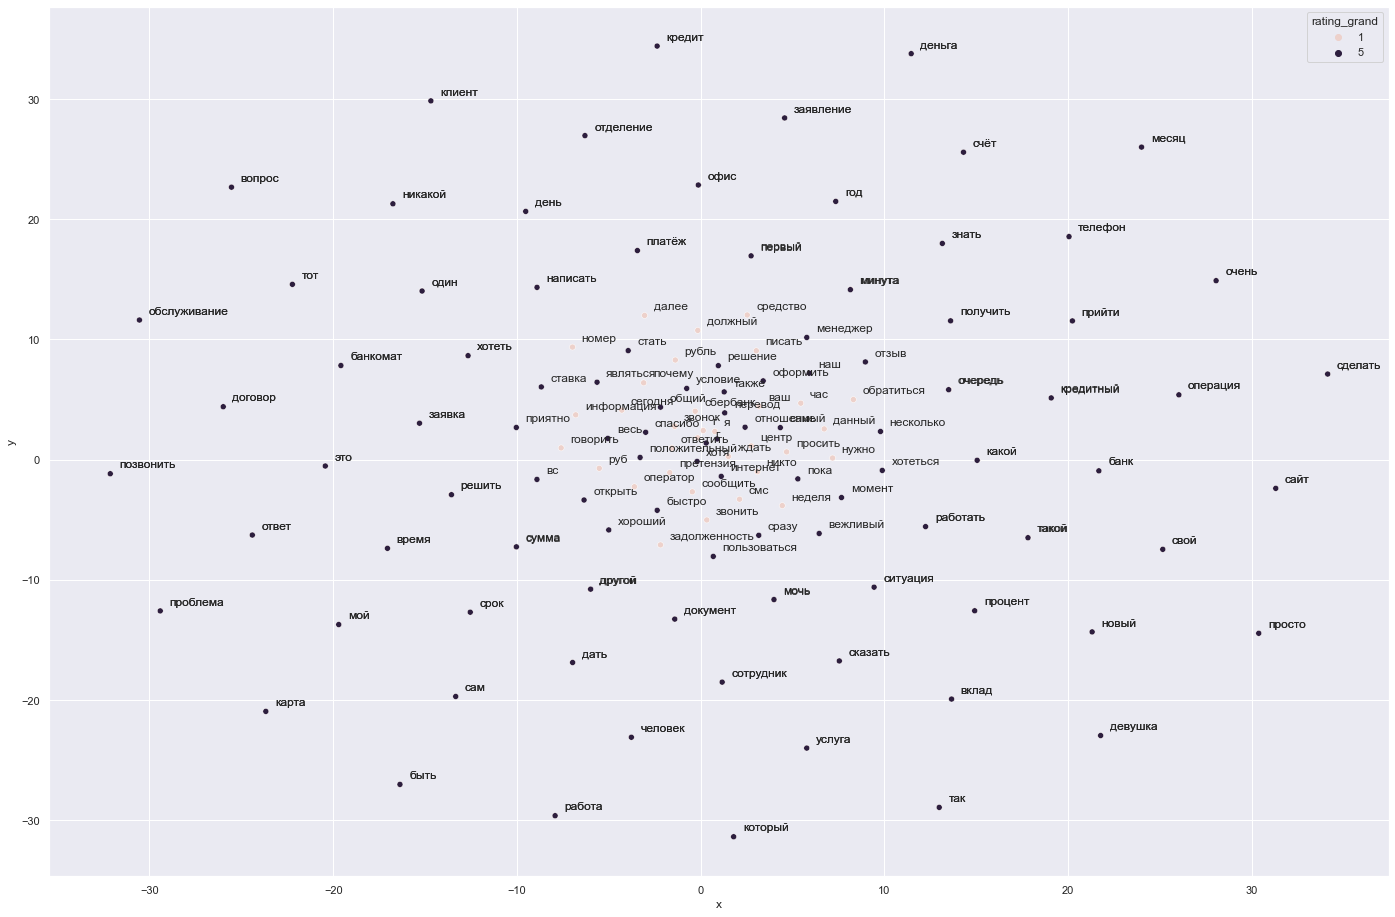

In [226]:
# Визуализируем распределение TSNE

sns.set(rc={'figure.figsize':(24,16)})
sns.scatterplot(data=lemm_df, x="x", y="y", hue="rating_grand")

for i in range(lemm_df.shape[0]):
    plt.text(x=lemm_df.x.to_list()[i]+0.5, y=lemm_df.y.to_list()[i]+0.5, s=lemm_df.lemm.to_list()[i])

Но какие-то осмысленные кластеры тут найти сложно...

задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [224]:
# Получаем координаты

banks_x = []
banks_y = []
banks = ['сбербанк', 'росбанк', 'ситибанк', 'промсвязьбанк', 'мкб', 'райффайзенбанк', 'россельхозбанк', 'альфабанк', 'бинбанк', 'транскредитбанк', 'импэксбанк']
for bank in banks:
    v1 = model_response.wv['отлично'] - model_response.wv['плохо']
    v2 = model_response.wv['быстро'] - model_response.wv['медленно']
    banks_x.append(np.dot(v1, model_response.wv[bank]))
    banks_y.append(np.dot(v2, model_response.wv[bank]))


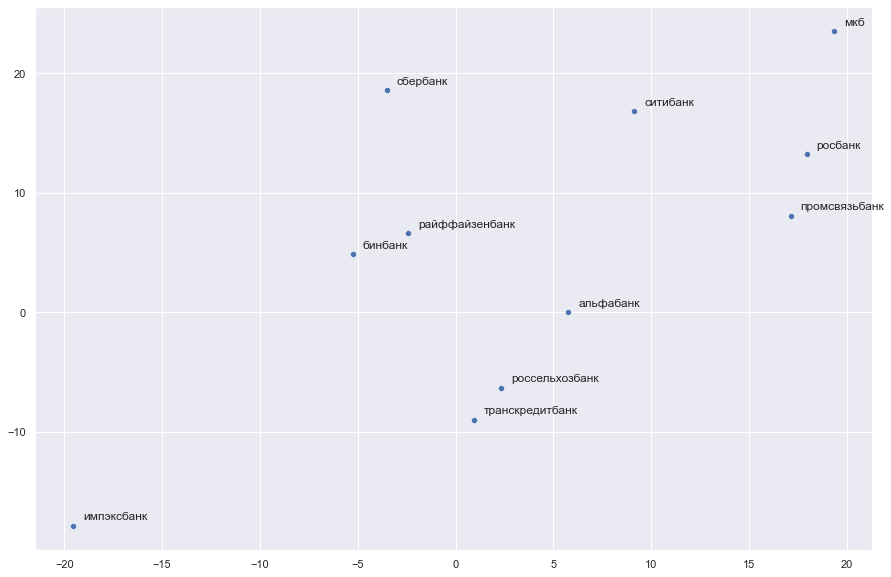

In [225]:
# Делаем визуализацию

sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x=banks_x, y=banks_y)

for i in range(len(banks)):
    plt.text(x=banks_x[i]+0.5, y=banks_y[i]+0.5, s=banks[i])

### Задание 2: Распространение метки

Я использовал шаблон построение графа из материалов - что получилось ниже.

In [123]:
# построение графа 

import igraph as ig
g = ig.Graph(directed=True)
for word in model_response.wv.index_to_key:
    g.add_vertex(word)
    
    
    
for word in model_response.wv.index_to_key:
    node = g.vs.select(name = word).indices[0]
    similar_words = model_response.wv.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)


In [129]:
print(g)

IGRAPH DNW- 31116 155580 --
+ attr: name (v), weight (e)
+ edges (vertex names):
                      банк -> сбербанк, сбер, ситибанк, росбанк, промсвязьбанк
                     карта -> счёт, карточка, кредитка, пластик, неименной
                       это -> такой, этот, подобный, дурак, некотор
                    деньга -> средство, денежка, наличность, дс, денюжка
                      день -> месяц, неделя, час, понедельник, сутки
                 отделение -> офис, филиал, осб, допофис, отд
                       мой -> свой, ваш, наш, мо, чей
                   который -> хотя, кто, поскольку, некорректно, следовательно
                    кредит -> ипотека, автокредит, рассрочка, потреба,
потребкредить
                 сотрудник -> оператор, специалист, менеджер, сотрудница,
работник
                    клиент -> вкладчик, посетитель, мщикома, клиентура,
клиенто
                      счёт -> карта, сч, депозит, картсчёт, скс
                   сказать -> говорить, сообщить